# Gower distance was used for both K-medoids and DBSCAN
# Kmeans was tested for experimental reasons


In [1]:
import gc

gc.collect()
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
from google.colab import files

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
uploaded = files.upload()

Saving CDN Client Error.csv to CDN Client Error.csv


In [3]:
# Combine these datasets
df = pd.read_csv('CDN Client Error.csv')

In [4]:
df.head()

,channel_id,timestamp,host_id,content_type,protocol,content_id,geo_location,user_id
0,0,2088-05-13 09:19:11,156,8,1,NaN,1303,0.0
1,0,2088-05-13 08:58:12,156,8,1,NaN,1514,0.0
2,0,2088-05-13 09:39:05,156,2,1,NaN,1,13.0
3,0,2088-05-13 09:54:15,156,8,1,NaN,1,0.0
4,0,2088-05-13 10:04:32,156,8,1,NaN,1,0.0


In [5]:
#replace NaN values with -1
df = df.fillna(-1)

In [6]:
df=df.drop_duplicates(keep='last')
df = df.drop(columns = 'timestamp', axis=1)
df = df.drop(columns = 'content_id', axis=1)

# K-medoids/DBSCAN with Gower distance

In [7]:
!pip install gower
!pip install scikit-learn-extra

  Created wheel for gower: filename=gower-0.0.5-py3-none-any.whl size=4231 sha256=bc7b8aacf5c3fcf285944dfcb16d6c1aa2c02e4d957ec237ac52d47751d3e931
  Stored in directory: /root/.cache/pip/wheels/3e/f9/9a/67122a959a424e9cbb4557a8366c871a30e31cd75f0d003db4
Successfully built gower
     |████████████████████████████████| 1.7 MB 5.2 MB/s 


In [8]:
#taking a portion of data to test gower distance
#gower may be inefficient because data is big and it takes time to be encoded
data=df[:10000]

In [9]:
import gower
from sklearn_extra.cluster import KMedoids
gower_mat = gower.gower_matrix(data,  cat_features = [True,True ,True,True, True,True])

# Kmedoids

No need for encoding here as gower handles both numerical and categorical data types

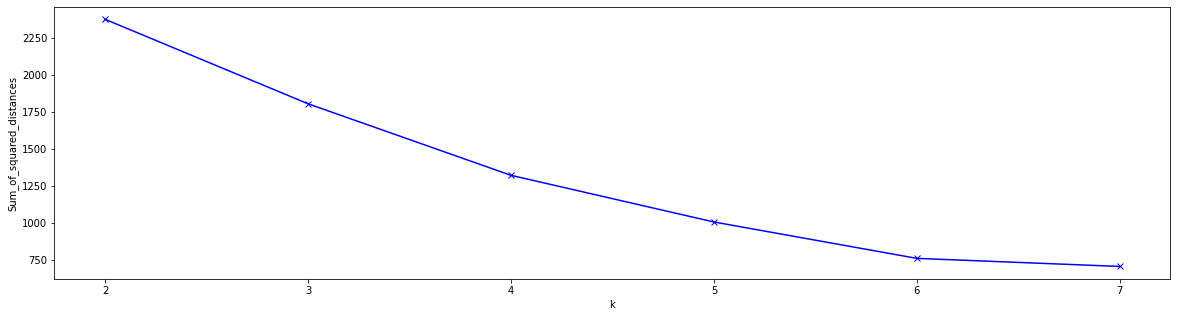

In [10]:
Sum_of_squared_distances = []
K = range(2,8)
for k in K:
    km = KMedoids(n_clusters = k, random_state = 0,  metric = 'precomputed', method = 'pam', init =  'k-medoids++').fit(gower_mat)
    Sum_of_squared_distances.append(km.inertia_)
plt.figure(figsize=(20,5))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.show()

K=6 is the optimal number of clusters according to the elbow method

K-Medoids clusters


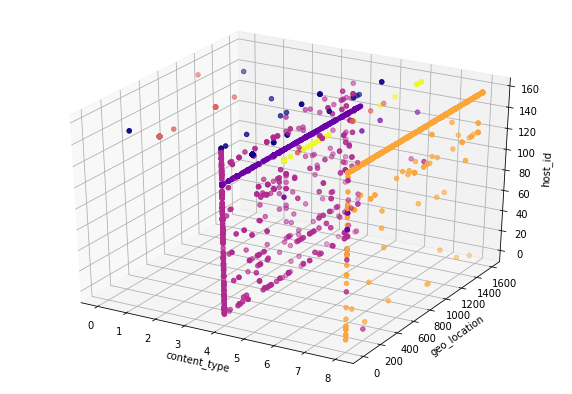

In [27]:
from mpl_toolkits.mplot3d import Axes3D

model = KMedoids(n_clusters = 6, random_state = 0, metric = 'precomputed', method = 'pam', init =  'k-medoids++').fit(gower_mat)
kmedoids_labels = model.labels_

fig = plt.figure(figsize=(10, 7))
ax = plt.axes(projection="3d")
ax.scatter3D(data['content_type'],data['geo_location'],data['host_id'],c=kmedoids_labels, cmap='plasma')
xLabel = ax.set_xlabel('content_type', linespacing=2)
yLabel = ax.set_ylabel('geo_location', linespacing=2)
zLabel = ax.set_zlabel('host_id', linespacing=2)
print("K-Medoids clusters")

In [11]:
def compute_score(silhouette ,davies_bouldin):
  return silhouette + 1/davies_bouldin

In [12]:
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_samples, silhouette_score


range_n_clusters = [5,6,7,8]
scores=[]
for n in range_n_clusters:  
  method = KMedoids(n_clusters = n, random_state = 0, metric = 'precomputed', method = 'pam', init =  'k-medoids++').fit(gower_mat)
  cluster_labels = method.fit_predict(gower_mat)
  davies_bouldin=davies_bouldin_score(gower_mat,cluster_labels)

  method = KMedoids(n_clusters = n, random_state = 0, metric = 'precomputed', method = 'pam', init =  'k-medoids++').fit(gower_mat)
  cluster_labels = method.fit_predict(gower_mat)
  silhouette=silhouette_score(gower_mat,cluster_labels)

  avg=compute_score(silhouette,davies_bouldin)
  scores.append(avg)

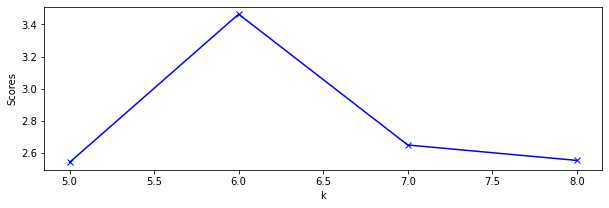

In [13]:
K = range(5,9)
plt.figure(figsize=(10,3))
plt.plot(K, scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Scores')
plt.show()

# Silhouette internal evaluation for kmedoids

n = 5  : average silhouette_score : 0.765


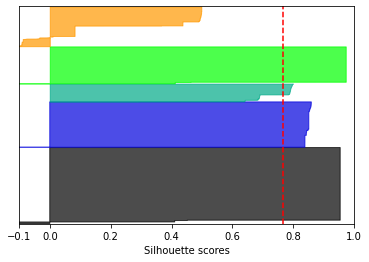

n = 6  : average silhouette_score : 0.844


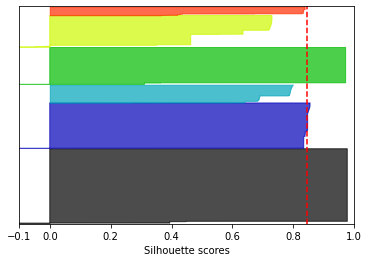

n = 7  : average silhouette_score : 0.718


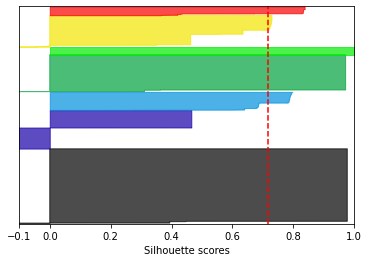

n = 8  : average silhouette_score : 0.739


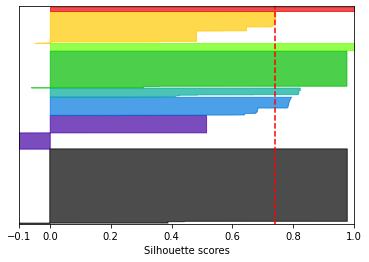

In [14]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

range_n_clusters = [5, 6,7,8]
for n in range_n_clusters:
    plt.xlim([-0.1, 1])
    plt.ylim([0, len(gower_mat) + (n + 1) * 10])
    method = KMedoids(n_clusters = n, random_state = 0, metric = 'precomputed', method = 'pam', init =  'k-medoids++').fit(gower_mat)
    cluster_labels = method.fit_predict(gower_mat)

    avg = silhouette_score(gower_mat, cluster_labels)
    print("n =", n," : average silhouette_score :", round(avg,3))
    sample_values = silhouette_samples(gower_mat, cluster_labels)
    y_lower = 10
    for i in range(n):
        ith_cluster = \
            sample_values[cluster_labels == i]
        ith_cluster.sort()
        size_i = ith_cluster.shape[0]
        y_upper = y_lower + size_i
        color = cm.nipy_spectral(float(i) / n)
        plt.fill_betweenx(np.arange(y_lower, y_upper),0, ith_cluster,facecolor=color, edgecolor=color, alpha=0.7)
        y_lower = y_upper + 10 
    plt.xlabel("Silhouette scores")
    plt.axvline(x=avg, color="red", linestyle="--")
    plt.yticks([])  
    plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.show()

# Silhouette internal evaluation for DBSCAN

In [15]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score


range_min = [10,20,30,40,50]
range_eps = [0.2,0.3,0.4] 
scores_silhouttes=[]
for m in range_min:
    for e in range_eps:
      method = DBSCAN(eps=e,min_samples=m,metric = "precomputed").fit(gower_mat)
      cluster_labels = method.labels_
      avg = silhouette_score(gower_mat, cluster_labels)
      print("m =",m,"e =",e," : average silhouette_score :", round(avg,3))
      scores_silhouttes.append(avg)

m = 10 e = 0.2  : average silhouette_score : 0.834
m = 10 e = 0.3  : average silhouette_score : 0.834
m = 10 e = 0.4  : average silhouette_score : 0.383
m = 20 e = 0.2  : average silhouette_score : 0.835
m = 20 e = 0.3  : average silhouette_score : 0.835
m = 20 e = 0.4  : average silhouette_score : 0.463
m = 30 e = 0.2  : average silhouette_score : 0.833
m = 30 e = 0.3  : average silhouette_score : 0.833
m = 30 e = 0.4  : average silhouette_score : 0.463
m = 40 e = 0.2  : average silhouette_score : 0.846
m = 40 e = 0.3  : average silhouette_score : 0.846
m = 40 e = 0.4  : average silhouette_score : 0.463
m = 50 e = 0.2  : average silhouette_score : 0.845
m = 50 e = 0.3  : average silhouette_score : 0.845
m = 50 e = 0.4  : average silhouette_score : 0.463


The optimal hyperparameters with highest silhoutte score for DBSCAN were epsilon=0.2 and min_samples=40

# Clusters description

In [17]:
method = DBSCAN(eps=0.2,min_samples=40,metric = "precomputed").fit(gower_mat)
#cluster_labels = method.fit_predict(gower_mat)
cluster_labels = method.labels_
df_clustered = data.assign(Cluster=cluster_labels)
grouped = df_clustered.groupby(['Cluster']).mean().round(1)
grouped

,channel_id,host_id,content_type,protocol,geo_location,user_id
Cluster,,,,,,
-1,1.4,111.3,6.9,0.9,688.0,5.5
0,0.0,156.0,8.0,1.0,397.5,0.0
1,0.0,156.0,2.0,1.0,4.3,13.0
2,0.0,156.0,5.0,1.0,4.7,2.0
3,2.0,123.0,4.0,1.0,394.1,7.0
4,1.0,156.0,6.0,0.2,45.5,33.3
5,6.0,65.0,4.0,1.0,516.1,1.0


In [18]:
no_clusters = len(np.unique(cluster_labels) )
no_noise = np.sum(np.array(cluster_labels) == -1, axis=0)
print('Estimated no. of clusters: %d' % no_clusters)
print('Estimated no. of noise points: %d' % no_noise)

Estimated no. of clusters: 7
Estimated no. of noise points: 199


We are interested in the cluster with id (-1). DBSCAN clusters anomalies to -1 as they do not belong to any other cluster

# Analyzing detected anomalies

In [19]:
import collections
collections.Counter(cluster_labels)[-1]
#161 out of 10000 were detected as anomalies (1.99%)

199

In [20]:
df_clustered.groupby('Cluster')['channel_id'].value_counts()[-1]
#most anomalies had channel_id=0

channel_id
0    136
6     20
4     15
3      9
1      8
7      8
2      2
5      1
Name: channel_id, dtype: int64

In [34]:
df_clustered.groupby('Cluster')['content_type'].value_counts()[-1]
#most anomalies had content_type=8

content_type
8    143
4     38
6     13
1      3
0      1
3      1
Name: content_type, dtype: int64

In [22]:
data['content_type'].value_counts() #overall distribution of content_type values in the sample data

5    3443
4    2941
2    1706
8    1493
6     412
1       3
3       1
0       1
Name: content_type, dtype: int64

In [23]:
df_clustered.groupby('Cluster')['geo_location'].value_counts()[-1]
#most anomalies had geo_location=1

geo_location
1       39
0       19
1586    15
1093     7
771      6
        ..
1348     1
1440     1
1488     1
1493     1
1519     1
Name: geo_location, Length: 75, dtype: int64

# Visualization of clusters

In [32]:
import plotly.express as px
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(data)
df_clustered["x_component"]=X_embedded[:,0]
df_clustered["y_component"]=X_embedded[:,1]

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [39]:
fig = px.scatter(df_clustered, x="x_component", y="y_component", hover_name="channel_id", color = "Cluster", size_max=40)
fig.update_layout(height=500)
fig.show()

# Davies bouldin and silhoutte scores for validation

In [26]:
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score

def compute_score(silhouette,davies_bouldin):
  return silhouette+ 1/davies_bouldin

range_min = [10,20,30,40,50]
range_eps = [0.2,0.3,0.4] 
scores=[]

for m in range_min:
    for e in range_eps:
      method = DBSCAN(eps=e,min_samples=m,metric = "precomputed").fit(gower_mat)
      cluster_labels = method.labels_
      davies_bouldin=davies_bouldin_score(gower_mat,cluster_labels)


      method = DBSCAN(eps=e,min_samples=m,metric = "precomputed").fit(gower_mat)
      cluster_labels = method.labels_
      silhoutte = silhouette_score(gower_mat, cluster_labels)
      
      
      avg=compute_score(silhoutte,davies_bouldin)
      scores.append(avg)

      print("minimum_samples =",m,"epsilon =",e," : average silhouette_score :", round(avg,3))

minimum_samples = 10 epsilon = 0.2  : average silhouette_score : 1.753
minimum_samples = 10 epsilon = 0.3  : average silhouette_score : 1.753
minimum_samples = 10 epsilon = 0.4  : average silhouette_score : 1.853
minimum_samples = 20 epsilon = 0.2  : average silhouette_score : 1.742
minimum_samples = 20 epsilon = 0.3  : average silhouette_score : 1.742
minimum_samples = 20 epsilon = 0.4  : average silhouette_score : 2.122
minimum_samples = 30 epsilon = 0.2  : average silhouette_score : 2.062
minimum_samples = 30 epsilon = 0.3  : average silhouette_score : 2.062
minimum_samples = 30 epsilon = 0.4  : average silhouette_score : 2.122
minimum_samples = 40 epsilon = 0.2  : average silhouette_score : 2.335
minimum_samples = 40 epsilon = 0.3  : average silhouette_score : 2.335
minimum_samples = 40 epsilon = 0.4  : average silhouette_score : 2.122
minimum_samples = 50 epsilon = 0.2  : average silhouette_score : 2.306
minimum_samples = 50 epsilon = 0.3  : average silhouette_score : 2.306
minimu

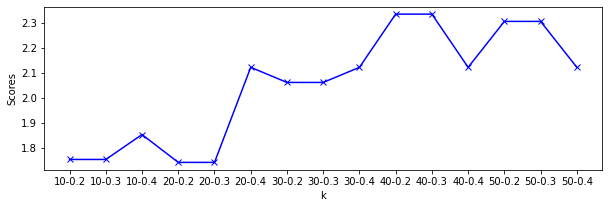

In [28]:
K = ["10-0.2","10-0.3","10-0.4","20-0.2","20-0.3","20-0.4","30-0.2","30-0.3","30-0.4","40-0.2","40-0.3","40-0.4","50-0.2","50-0.3","50-0.4"]
plt.figure(figsize=(10,3))
plt.plot(K, scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Scores')
plt.show()